### 1. Первые шаги

In [1]:
!git clone https://github.com/mipt-tim-2023/projects.git

Cloning into 'projects'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 415 (delta 56), reused 119 (delta 30), pack-reused 263
Receiving objects: 100% (415/415), 57.31 MiB | 11.66 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [3]:
table = pd.read_csv('/content/projects/YCombinator 2006-2023.csv')

In [4]:
text_columns = [
    'Companies',
    'Deal Synopsis',
    'Financing Status Note'
]

target_column = 'Post Valuation'

X_data = table[text_columns]
y_data = table[target_column]

nan_mask = y_data.isna()

X_data = X_data.loc[~nan_mask]
y_data = y_data.loc[~nan_mask]
y_data = np.log(y_data)

In [ ]:
X_concat = (X_data.iloc[:, 0].astype(str) + '; ' + X_data.iloc[:, 1].astype(str)).values

In [ ]:
print(X_data.shape)

(770, 3)


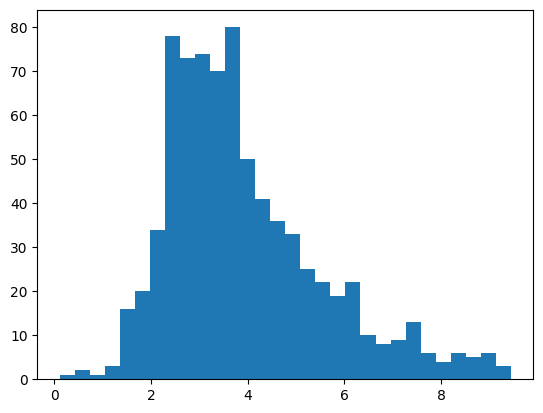

In [ ]:
plt.hist(y_data, bins=30);

Теперь будем уже предсказывать.

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [ ]:
embs = model.encode(X_concat, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
embs.shape

(770, 384)

In [ ]:
emb_dim = 384
hid_dim = 10

regressor = nn.Sequential(
    nn.Linear(emb_dim, hid_dim),
    nn.ReLU(),
    nn.Linear(hid_dim, 1)
).cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(),
                             lr=1e-3)

In [ ]:
X_embs_train, X_embs_test, y_train, y_test = train_test_split(embs, y_data.values, train_size=0.8)

In [ ]:
X_embs_train = torch.FloatTensor(X_embs_train).cuda()
X_embs_test = torch.FloatTensor(X_embs_test).cuda()
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [ ]:
from tqdm.auto import tqdm
from IPython.display import clear_output

n_epochs = 2000
show_every = 20

train_losses = []
test_losses = []
i_start = 0

In [ ]:
for i in tqdm(range(i_start, n_epochs)):
    regressor.train()
    optimizer.zero_grad()

    preds = regressor(X_embs_train).cpu().squeeze()
    loss = loss_fn(preds, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    regressor.eval()
    with torch.no_grad():
        preds = regressor(X_embs_test).cpu().squeeze()
        loss = loss_fn(preds, y_test)
        test_losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

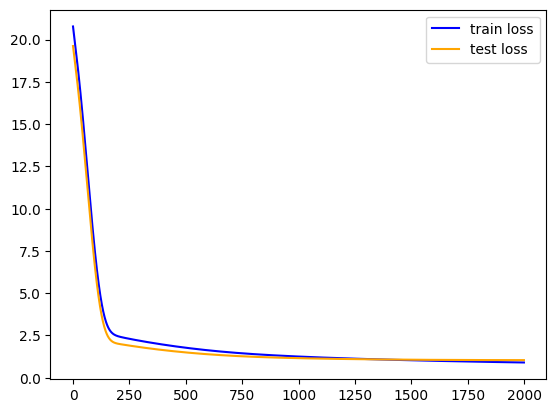

In [ ]:
plt.plot(train_losses, color='blue', label='train loss')
plt.plot(test_losses, color='orange', label='test loss')
plt.legend()

**Вывод**

1. MSE- ошибка около $2.3$, поэтому реальная ошибка может быть в $e^{\sqrt{2.3}} \approx 4.5$ раз.
2. Для большей точности нужно больше данных.
3. Для малой точности можно предсказывать пакет, куда попала компания. Пакеты отличаются по капитализации в $4.5$ раз

Теперь предскажем на всех недостающий признак post valuation

In [ ]:
X_data = table[text_columns]
X_concat = (X_data.iloc[:, 0].astype(str) + '; ' + X_data.iloc[:, 1].astype(str)).values

X_all_embs = torch.FloatTensor(model.encode(X_concat, batch_size=64, show_progress_bar=True)).cuda()

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
preds = regressor(X_all_embs).cpu().detach().squeeze().numpy()

In [ ]:
table['predicted post valuation'] = np.exp(preds)

In [ ]:
table[['predicted post valuation', 'Post Valuation']]

,predicted post valuation,Post Valuation
0,29.418037,14.83
1,8.696840,6.03
2,13.837018,NaN
3,3.108381,NaN
4,12.106389,4.62
...,...,...
1342,63.387295,NaN
1343,27.388449,NaN
1344,97.124390,65.00
1345,21.306845,NaN


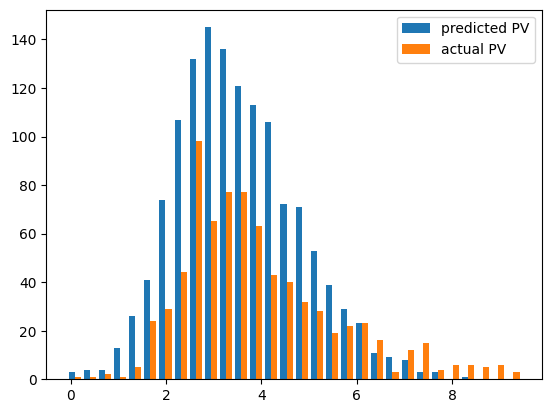

In [ ]:
plt.hist(np.log(table[['predicted post valuation', 'Post Valuation']]), bins=30, label=['predicted PV', 'actual PV']);
plt.legend()

### 2. Доработка

1. Первое задание

- разбить по бинам: [1-5), [5-10), 10-50, 50-100, 100-500, 500-1000
- тяготение вверх
- отсечка по 1MK


2. Второе задание

7-ми, 8-ми, 9-ти значные компании и попробовать для каждой из них сделать то же самое и далее: по капитализации - описание.

In [5]:
table = pd.read_csv('/content/projects/YCombinator 2006-2023.csv')

In [29]:
text_columns = [
    'Companies',
    'Deal Synopsis',
    'Financing Status Note'
]

target_column = 'Post Valuation'

X_data = table[text_columns]
y_data = table[target_column]

nan_mask = y_data.isna()

X_data = X_data.loc[~nan_mask]
y_data = y_data.loc[~nan_mask]

X_concat = (X_data.iloc[:, 0].astype(str) + '; ' + X_data.iloc[:, 1].astype(str)).values

In [30]:
def get_bin(x, bins=[5, 10, 50, 100, 500, 1000, np.inf]):
    for i, val in enumerate(bins):
        if x < val:
            return i
    assert False

bin_names = ['<5',
             '[5, 10)',
             '[10, 50)',
             '[50, 100)',
             '[100, 500)',
             '[500, 1000)',
             '>1000']

In [47]:
y_bins = np.array([get_bin(y) for y in y_data], dtype=np.int32)

Text(0.5, 1.0, 'Количество компаний по капитализации')

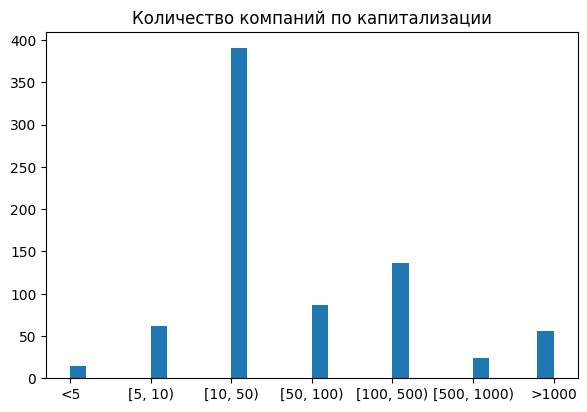

In [32]:
plt.figure(figsize=(6, 4))
plt.hist(y_bins, bins=30);
plt.xticks(np.arange(7), bin_names);
plt.tight_layout()
plt.title('Количество компаний по капитализации')

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

In [35]:
embs = model.encode(X_concat, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [36]:
embs.shape

(770, 384)

In [95]:
emb_dim = 384
hid_dim = 10
out_dim = len(bin_names)

classifier = nn.Sequential(
    nn.Linear(emb_dim, hid_dim),
    nn.ReLU(),
    nn.Linear(hid_dim, out_dim),
).cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(),
                             lr=3e-4)

In [96]:
X_embs_train, X_embs_test, y_train, y_test = train_test_split(embs, y_bins, train_size=0.8)

In [97]:
X_embs_train = torch.FloatTensor(X_embs_train).cuda()
X_embs_test = torch.FloatTensor(X_embs_test).cuda()
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [98]:
from tqdm.auto import tqdm
from IPython.display import clear_output

n_epochs = 2000
show_every = 20

train_losses = []
test_losses = []

train_acc = []
test_acc = []

train_corr = []
test_corr = []
i_start = 0

In [ ]:
from sklearn.metrics import accuracy_score


for i in tqdm(range(i_start, n_epochs)):
    classifier.train()
    optimizer.zero_grad()

    preds = classifier(X_embs_train).cpu().squeeze()
    loss = loss_fn(preds, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    train_pred = preds.argmax(axis=1)
    train_acc.append(accuracy_score(train_pred, y_train))

    train_corr.append(np.corrcoef(train_pred, y_train)[0, 1])
    classifier.eval()
    with torch.no_grad():
        preds = classifier(X_embs_test).cpu().squeeze()
        loss = loss_fn(preds, y_test)
        test_losses.append(loss.item())

        test_pred = preds.argmax(axis=1)
        test_acc.append(accuracy_score(test_pred, y_test))
        test_corr.append(np.corrcoef(test_pred, y_test)[0, 1])

Text(0.5, 0, 'epoch')

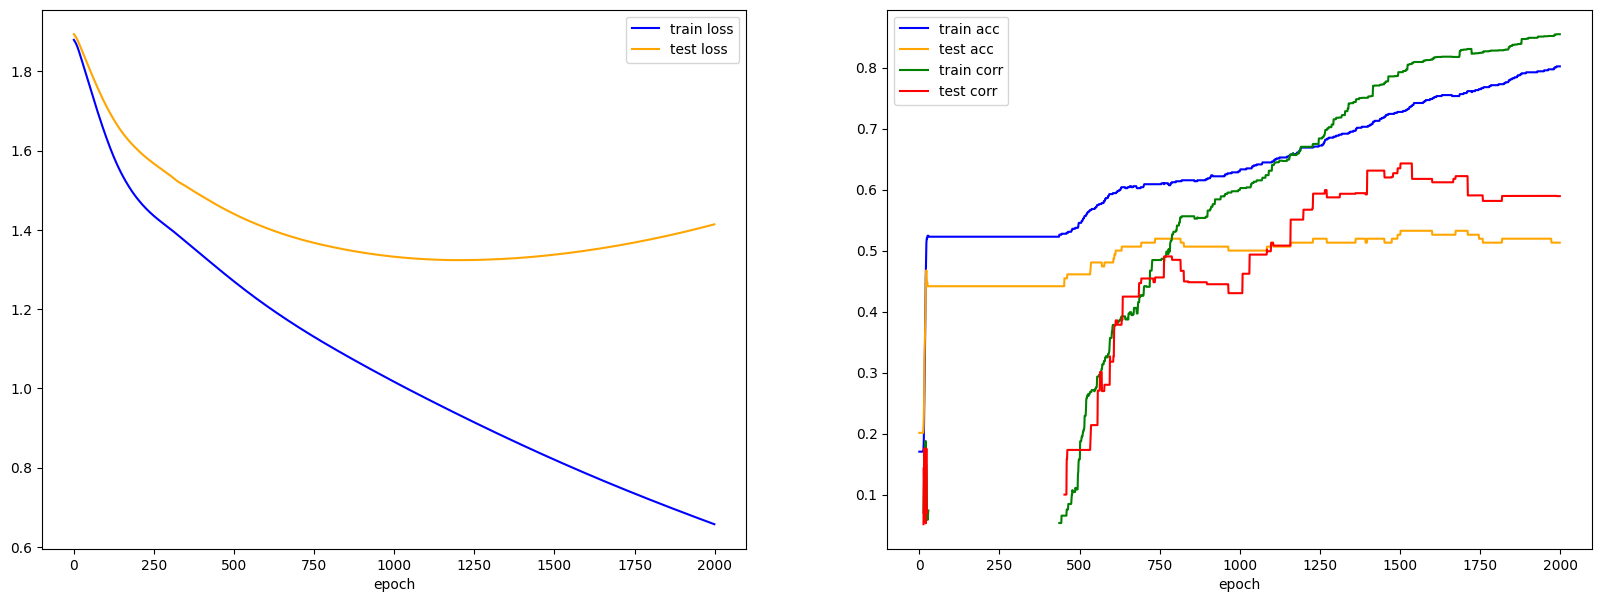

In [102]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='blue', label='train loss')
plt.plot(test_losses, color='orange', label='test loss')
plt.legend()
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(train_acc, color='blue', label='train acc')
plt.plot(test_acc, color='orange', label='test acc')

plt.plot(train_corr, color='green',  label='train corr')
plt.plot(test_corr,  color='red', label='test corr')

plt.legend()
plt.xlabel('epoch')

Как видим, получается в итоге угадать в $55\%$ случаях правильный бин.

Тем не менее, корреляция $\approx 0.6$, что подтверждает нахождение зависимости